In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import os
import sys 
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.path.insert(0, "../src")
import severson_data
import models
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [2]:
colours = ['#208F90', '#8F2317','#17608F','#8F5F17','#f2f3f4','#E56399','#DE6E4B']
golden_ratio =1.618

sns.set_palette(sns.color_palette(colours))


colors = cycler('color',
                colours)
plt.rc('axes', facecolor='#FFFFFF', edgecolor='#000000',
       axisbelow=True, grid=True, prop_cycle=colors)

In [3]:
config = configparser.ConfigParser()
config.read('../config.ini');
result_path =config['PATHS']['result_path'] 

In [4]:
model_path  = '../models/final_models_nifl'
fig_path =config['PATHS']['figure_path'] 
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [5]:
results_all = pd.concat(results_list, axis=1).T.infer_objects()

results_all.experiment_name.unique()


array(['NumCycles', 'NumBatteries'], dtype=object)

In [7]:
my_sue = 'NumCycles'
results = results_all[results_all.experiment_name == my_sue]
results = results.reset_index()

my_results = None

if results.experiment_name[0] == 'NumCycles':

    my_results = results[[
         'sequence_length', 'best_val_loss',
         'rmse_state_val', 'rmse_state_test', 'dropout', 'hidden_size','hidden_size_lstm',
          ]].groupby([ 'sequence_length','hidden_size','hidden_size_lstm', ]).mean()
    

if results.experiment_name[0] == 'NumBatteries':

    my_results = results[[
         'sequence_length', 'best_val_loss',
         'rmse_state_val', 'rmse_state_test', 'train_percentage','hidden_size','hidden_size_lstm',
          ]].groupby([ 'train_percentage','hidden_size','hidden_size_lstm', ]).mean()
    



my_results

,,,best_val_loss,rmse_state_val,rmse_state_test,dropout
sequence_length,hidden_size,hidden_size_lstm,,,,
20,32,32,-3.70,289.65,444.42,0.00
30,32,32,-3.76,238.07,293.03,0.00
40,32,32,-3.94,150.62,230.37,0.00
50,32,32,-3.97,159.07,324.08,0.00
60,32,32,-3.97,142.30,363.24,0.00
70,32,32,-4.01,160.95,365.25,0.00
80,32,32,-4.05,119.10,193.37,0.00
90,32,32,-4.08,103.52,180.84,0.00
100,32,32,-4.01,113.12,164.55,0.00


In [8]:
results =results[results.dropout  == .0]

results =results[results.hidden_size_lstm  == 32]
results =results[results.hidden_size  == 32]
results =results[results.sequence_length  == 100]
results = results.sort_values('seed')
results = results.reset_index()


In [9]:
best_model_idx = results.rmse_state_val.argmin()
seq_length = 100
start_cycle = results.start[best_model_idx]



hidden_size = results.hidden_size[best_model_idx]

# load data

In [10]:
if 'data_dict' not in locals(): # just takes a lot of time
    data_path = config['DATASET']['severson_path'] 
    bat_dicts = severson_data.load_data_single(data_path)
data_dict = {**bat_dicts[0], **bat_dicts[1], }
# data_dict = {**bat_dicts[0], **bat_dicts[1], **bat_dicts[2],}

x, y, c, var  = severson_data.get_capacity_input(data_dict, num_offset=0, start_cycle = 10, stop_cycle = seq_length)

x_scaled  = severson_data.scale_x(x,y)

x_preprocessed = severson_data.remove_outliers(x_scaled,y)
x_smoothed = severson_data.smooth_x(x_preprocessed,y, num_points=20)

C:\Users\lauri\AppData\Roaming\Python\Python39\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [11]:
x, y, c, var  = severson_data.get_capacity_input(data_dict, num_offset=0, start_cycle = 10, stop_cycle = 100)
_,_,_, var_old  = severson_data.get_capacity_input(data_dict, num_offset=0, start_cycle = 13, stop_cycle = 100)


In [12]:
train_idxs , val_idxs,test_idxs= severson_data.get_split(len(x), seed =42)

qc_variance_scaler = StandardScaler().fit(var[train_idxs]) 
var = qc_variance_scaler.transform(var)

augmented_data =np.hstack([c, var]) 


In [13]:

train_x, train_y , train_s = severson_data.assemble_dataset(x_preprocessed[train_idxs], y[train_idxs],  augmented_data[train_idxs],seq_len = seq_length)
_, smoothed_y , _ = severson_data.assemble_dataset(x_smoothed[train_idxs], y[train_idxs],  augmented_data[train_idxs],seq_len = seq_length)

min_val = .85
max_val = 1

capacity_output_scaler = MinMaxScaler((-1, 1), clip=False).fit(
    np.maximum(np.minimum(smoothed_y[:, 0:1], max_val), min_val)
)

# Load Models

In [14]:

input_dim = train_x.shape[2]   # Number of input features (e.g. discharge capacity)
num_augment = train_s.shape[1]  # three  values of charging schedule (avg and last) plus the variance



my_models = [models.Uncertain_LSTM(train_x.shape[2] , 
                            train_s.shape[1] , 
                            num_hidden =  results.iloc[i].hidden_size, 
                              
                            num_hidden_lstm =  results.iloc[i].hidden_size_lstm, 
                            seq_len= results.sequence_length[best_model_idx], 
                            n_layers =2, 
                            dropout =.0).to(device) for i, _ in enumerate(results.file_name)] 
for i, file_name in enumerate(results.file_name):
    my_models[i].load_state_dict(torch.load(oj(model_path,file_name+".pt")))
    my_models[i] = my_models[i].to(device)

# Run models on test set

In [15]:

cycle_dict = {}
num_samples = 10
my_quantile = .1
num_models = 25
max_steps = 3500

used_idxs =  test_idxs#train_idxs[10:20]#for actually new data, use test_idxs

In [98]:

# for seq_length in [40,]:
for seq_length in [300,]:  
# for seq_length in [800,]:  
    test_seq_list = []
    test_life_pred_list = []
    test_seq_std_list = []

    all_outputs_arr = np.empty( (len(used_idxs),max_steps,num_models, num_samples,))
    # used_idxs =  np.arange(len(x))#for actually new data, use test_idxs
    for i,model in tqdm(enumerate(my_models[:num_models])):

        supp_val_data =  np.hstack([c[used_idxs, :3], var[used_idxs],np.ones((len(used_idxs),1))*np.log(seq_length) ])

        test_seq = x_preprocessed[used_idxs][:, :seq_length,None  ].copy()
        extended_seq = np.swapaxes(np.reshape(np.repeat(np.swapaxes(test_seq, 0,-1)[:,:,:,None],num_samples, axis =-1), (1, seq_length, -1)),0,-1)

        extended_supp_data = np.swapaxes(np.reshape(np.repeat(np.swapaxes(supp_val_data, 0,-1)[:,:,None],num_samples, axis =-1), (supp_val_data.shape[1], -1)),0,-1)

        with torch.no_grad():
            while((np.all(extended_seq[:,-1] < 1e-3) == False ) *(extended_seq.shape[1] < max_steps)):


                supp_val_data_torch = torch.from_numpy(extended_supp_data).to(device).float()

                test_seq_torch = torch.from_numpy(extended_seq[:, - seq_length:]).to(device).float()

                model.reset_hidden_state()        
                (state_mean_mean, state_var) = model(test_seq_torch, supp_val_data_torch)
                if num_samples >1:
                    state_mean_noisy   = state_mean_mean  +  torch.normal(0, (torch.sqrt(state_var)))   
                else:
                    state_mean_noisy   = state_mean_mean 

                state_mean_transformed = torch.from_numpy(capacity_output_scaler.inverse_transform(state_mean_noisy.cpu().numpy())).to(device)

                state_mean_transformed[:,0] = state_mean_transformed[:,0]*(test_seq_torch[:, -1, 0 ])

                extended_supp_data[:,-1] = np.log(np.exp(extended_supp_data[:,-1])+1)
                extended_seq = np.hstack([extended_seq, state_mean_transformed.cpu().numpy()[:, None]])
        used_steps = extended_seq.shape[1]
        reshaped = np.swapaxes(np.reshape(np.swapaxes(extended_seq,0,1),(1,used_steps, -1, num_samples)),0,-2)
        all_outputs_arr[:,:used_steps,i,:] = reshaped[:,:,0]

    all_outputs_arr = np.reshape(np.transpose(all_outputs_arr, (0,2,3, 1)), (len(used_idxs), -1, max_steps))
    cycle_dict[seq_length] = np.copy(all_outputs_arr)

0it [00:00, ?it/s]

In [37]:
num_per_ensemble = 5
num_ensembles = int(num_models/ num_per_ensemble)
pred_arr = np.empty((num_ensembles, len(used_idxs)))
for j in range(num_ensembles):
    for i in range(len(used_idxs)):
        pred_arr[j,i] = ((all_outputs_arr[i] <1e-2).argmax(axis=1)[j*num_samples*num_per_ensemble:(j+1)*num_per_ensemble*num_samples]).mean()
print("RMSE", np.sqrt(np.mean(np.square(pred_arr- y[used_idxs][None,:]), axis=1)).mean())
print("MAE", (np.mean(np.abs(pred_arr- y[used_idxs][None,:]), axis=1)).mean())

RMSE 110.79604296968837
MAE 78.41142857142856


In [38]:
np.sqrt(np.mean(np.square(pred_arr- y[used_idxs][None,:]), axis=1))

array([107.40515204, 101.3483929 ,  95.85055382,  83.15532535,
       166.22079075])

In [39]:
num_per_ensemble = 5
num_ensembles = int(num_models/ num_per_ensemble)
pred_arr = np.empty((num_ensembles, len(used_idxs)))
std_arr = np.empty((num_ensembles, len(used_idxs)))
for j in range(num_ensembles):
    for i in range(len(used_idxs)):
        pred_arr[j,i] = ((all_outputs_arr[i] <1e-2).argmax(axis=1)[j*num_samples*num_per_ensemble:(j+1)*num_per_ensemble*num_samples]).mean()
        std_arr[j,i] = ((all_outputs_arr[i] <1e-2).argmax(axis=1)[j*num_samples*num_per_ensemble:(j+1)*num_per_ensemble*num_samples]).std()


In [48]:
acceptable_err = 50
err_dict = {}
std_std_dict = {}
ahh_plot = {}
for key in cycle_dict.keys():

    all_outputs_arr = cycle_dict[key]
    num_per_ensemble = 5
    num_ensembles = int(num_models/ num_per_ensemble)
    pred_arr = np.empty((num_ensembles, len(used_idxs)))
    std_arr = np.empty((num_ensembles, len(used_idxs)))
    for j in range(num_ensembles):
        for i in range(len(used_idxs)):
            pred_arr[j,i] = ((all_outputs_arr[i] <1e-2).argmax(axis=1)[j*num_samples*num_per_ensemble:(j+1)*num_per_ensemble*num_samples]).mean()
            std_arr[j,i] = ((all_outputs_arr[i] <1e-2).argmax(axis=1)[j*num_samples*num_per_ensemble:(j+1)*num_per_ensemble*num_samples]).std()

    err_dict[key] = (np.abs(pred_arr - y[test_idxs]) <acceptable_err).mean()
    std_std_dict[key] = (std_arr ).mean()
    

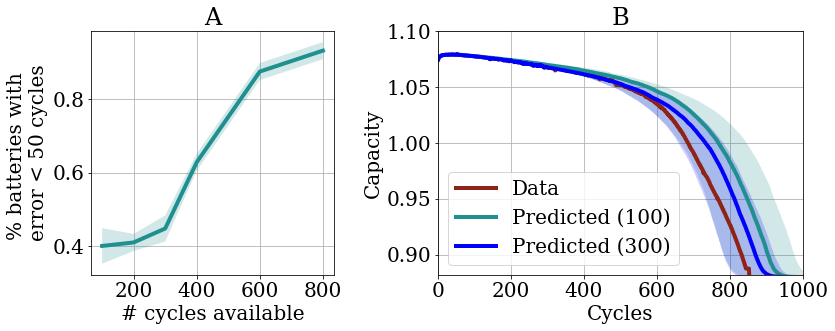

In [49]:
IDX = 16
plt.rc('font', family='serif', size = 20)
fig, axes = plt.subplots(ncols = 2, figsize= (12,5), gridspec_kw={'width_ratios': [1, 1.5]})
lists = sorted(err_dict.items()) # sorted by key, return a list of tuples
lists2 = sorted(st_dict.items()) # sorted by key, return a list of tuples
linewidth = 4
x_plot, y_plot = zip(*lists)
x_plot, std_plot = zip(*lists2)


axes[0].plot(x_plot,y_plot, linewidth = linewidth)
axes[0].fill_between(x_plot, np.asarray(y_plot)+ np.asarray(std_plot),np.asarray(y_plot)- np.asarray(std_plot), facecolor=colours[0], alpha=0.2, label ='Err')

lists2 = sorted(std_std_dict.items()) # sorted by key, return a list of tuples
linewidth = 4


axes[0].set_xlabel("# cycles available", )
axes[0].set_ylabel("% batteries with \nerror < {acceptable_err} cycles".format(acceptable_err = acceptable_err))
axes[1].plot(x_preprocessed[used_idxs[IDX]]* (1.1-.8*1.1) + .8*1.1, c = colours[1], label = 'Data',linewidth = linewidth)


axes[1].plot(np.quantile(cycle_dict[100][IDX][:50], .5, axis = 0)* (1.1-.8*1.1) + .8*1.1, c= colours[0], label = 'Predicted (100)',linewidth = linewidth)
lower_limit = np.quantile(cycle_dict[100][IDX][:50], my_quantile/2, axis = 0)* (1.1-.8*1.1) + .8*1.1
upper_limit = np.quantile(cycle_dict[100][IDX][:50], 1-my_quantile/2, axis = 0)* (1.1-.8*1.1) + .8*1.1
axes[1].fill_between(np.arange(3500), upper_limit, lower_limit , facecolor=colours[0], alpha=0.2)

axes[1].plot(np.quantile(cycle_dict[300][IDX][:50], .5, axis = 0)* (1.1-.8*1.1) + .8*1.1, c= 'b', label = 'Predicted (300)',linewidth = linewidth)
lower_limit = np.quantile(cycle_dict[300][IDX][:50], my_quantile/2, axis = 0)* (1.1-.8*1.1) + .8*1.1
upper_limit = np.quantile(cycle_dict[300][IDX][:50], 1-my_quantile/2, axis = 0)* (1.1-.8*1.1) + .8*1.1
axes[1].fill_between(np.arange(3500), upper_limit, lower_limit , facecolor='b', alpha=0.2)
axes[1].set_ylabel("Capacity", )
axes[1].set_xlabel("Cycles", )
axes[1].set_xlim(0,1000)
axes[1].set_ylim(.8*1.1+.002,1.1)
axes[1].legend(loc =0)
axes[0].title.set_text("A")
axes[1].title.set_text("B")
plt.tight_layout()

plt.savefig(oj(fig_path,"projection.pdf".format(seq_length, )) )